In [1]:
import sympy as sp
sp.init_printing(use_latex ='mathjax')

import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import os
import pandas as pd
import scipy as sc
from sklearn.linear_model import LinearRegression
from lmfit import Model
import lmfit

## Brittany: set this to be False
using_windows = True

In [2]:
#Define column names and read csv file

base1 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/ResonanceCurves/'
file1 = os.path.join('Array01.00r0.5p3Device1.2Drum1Couping500','Data.csv')

base2 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/ResonanceCurves/'
file2 = os.path.join('Array01.00r0.5p3Device1.2RandomNodeCoupling500','Data.csv')

if using_windows:
    base1 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\ResonanceCurves'
    base2 = base1

path1 = os.path.join(base1, file1)
path2 = os.path.join(base2, file2)

colnames= ['SweepVal', 'F', 'R', 'theta', 'NEP_BW', 'R_ref', 'theta_ref', 'Amp', 'Phase']

df1 = pd.read_csv(path1, names = colnames)
df2 = pd.read_csv(path2, names = colnames)

In [3]:
## Add columns in units of radians

#Convert to radians (pi radians = 180 degrees)
df1['rad'] = df1.theta * np.pi / 180
df2['rad'] = df2.theta * np.pi / 180

#Convert to radians per second (2pi radians = 1 cycle)
df1['w'] = df1.F * 2 * np.pi 
df2['w'] = df2.F * 2 * np.pi

## Add unwrapped column for phase
# The default period for unwrapping is 2 pi, so it's easiest to unwrap in radians
df1['rad_unwrapped_uncorrected'] = np.unwrap(df1.rad) 
df1['theta_unwrapped_uncorrected'] = df1.rad_unwrapped_uncorrected * 180/np.pi
df2['rad_unwrapped_uncorrected'] = np.unwrap(df2.rad)
df2['theta_unwrapped_uncorrected'] = df2.rad_unwrapped_uncorrected * 180/np.pi



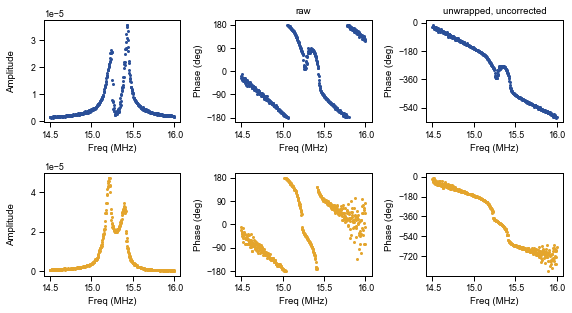

In [5]:
#Plots for paper

sns.set_context('paper')

m1_col = "#2A4F98"
m2_col = "#E4A52D"

fig, ((ax1, ax2, ax5), (ax3, ax4, ax6)) = plt.subplots(2, 3, figsize = (9.3,4.7)) 
                                            # formerly (7.3,4.7) for two columns

ax1.plot(df1.F/1e6, df1.R, '.', markersize = 4, color = m1_col)
ax1.set_xlabel('Freq (MHz)')
ax1.set_ylabel('Amplitude\n')

ax2.plot(df1.F/1e6, df1.theta, '.', markersize = 4, color = m1_col)
ax2.set_xlabel('Freq (MHz)')
ax2.set_ylabel('Phase (deg)')
ax2.yaxis.set_major_locator(plt.MultipleLocator(90))
ax2.set_title('raw')

ax5.plot(df1.F/1e6, df1.theta_unwrapped_uncorrected, '.', markersize = 4, color = m1_col)
ax5.set_xlabel('Freq (MHz)')
ax5.set_ylabel('Phase (deg)')
ax5.yaxis.set_major_locator(plt.MultipleLocator(180))
ax5.set_title('unwrapped, uncorrected')

ax3.plot(df2.F/1e6, df2.R, '.', markersize = 4, color = m2_col)
ax3.set_xlabel('Freq (MHz)')
ax3.set_ylabel('Amplitude\n')

ax4.plot(df2.F/1e6, df2.theta, '.', markersize = 4, color = m2_col)
ax4.set_xlabel('Freq (MHz)')
ax4.set_ylabel('Phase (deg)')
ax4.yaxis.set_major_locator(plt.MultipleLocator(90))


ax6.plot(df2.F/1e6, df2.theta_unwrapped_uncorrected, '.', markersize = 4, color = m2_col)
ax6.set_xlabel('Freq (MHz)')
ax6.set_ylabel('Phase (deg)')
ax6.yaxis.set_major_locator(plt.MultipleLocator(180))


plt.subplots_adjust(hspace = 0.5, wspace = 0.4)

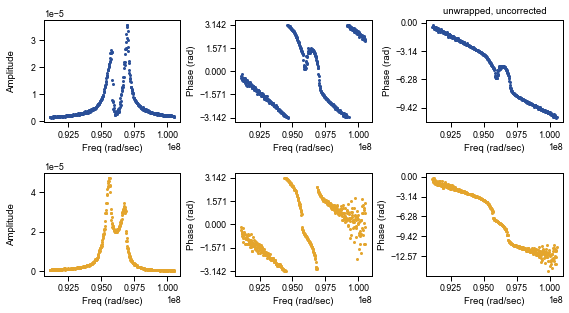

In [6]:
#Plots again in radians

sns.set_context('paper')

m1_col = "#2A4F98"
m2_col = "#E4A52D"

fig, ((ax1, ax2, ax5), (ax3, ax4, ax6)) = plt.subplots(2, 3, figsize = (9.3,4.7)) 
                                            # formerly (7.3,4.7) for two columns

ax1.plot(df1.w, df1.R, '.', markersize = 4, color = m1_col)
ax1.set_xlabel('Freq (rad/sec)')
ax1.set_ylabel('Amplitude\n')

ax2.plot(df1.w, df1.rad, '.', markersize = 4, color = m1_col)
ax2.set_xlabel('Freq (rad/sec)')
ax2.set_ylabel('Phase (rad)')
ax2.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))

ax5.plot(df1.w, df1.rad_unwrapped_uncorrected, '.', markersize = 4, color = m1_col)
ax5.set_xlabel('Freq (rad/sec)')
ax5.set_ylabel('Phase (rad)')
ax5.yaxis.set_major_locator(plt.MultipleLocator(np.pi))
ax5.set_title('unwrapped, uncorrected')

ax3.plot(df2.w, df2.R, '.', markersize = 4, color = m2_col)
ax3.set_xlabel('Freq (rad/sec)')
ax3.set_ylabel('Amplitude\n')

ax4.plot(df2.w, df2.rad, '.', markersize = 4, color = m2_col)
ax4.set_xlabel('Freq (rad/sec)')
ax4.set_ylabel('Phase (rad)')
ax4.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))

ax6.plot(df2.w, df2.rad_unwrapped_uncorrected, '.', markersize = 4, color = m2_col)
ax6.set_xlabel('Freq (rad/sec)')
ax6.set_ylabel('Phase (rad)')
ax6.yaxis.set_major_locator(plt.MultipleLocator(np.pi ))


plt.subplots_adjust(hspace = 0.5, wspace = 0.4)

In [7]:
#Fit linear part of phase lag to subtract from graph

#Define linear portion of less than 15MHz for fit
mk = df1.F < 15.00*10**6
x1 = df1[['w']][mk].values
y1 = df1.rad[mk].values # this works the same if you use df1.rad_unwrapped_uncorrected

x2 = df2[['w']][mk].values
y2 = df2.rad[mk].values # this works the same if you use df2.rad_unwrapped_uncorrected

#Perform linear fit using sklearn
model1 = LinearRegression().fit(x1,y1)
r_sq1 = model1.score(x1,y1)

model2 = LinearRegression().fit(x2,y2)
r_sq2 = model2.score(x2,y2)

<AxesSubplot:title={'center':'Model(linear)'}, xlabel='frequency (rad/sec)', ylabel='Raw measured phase (rad)'>

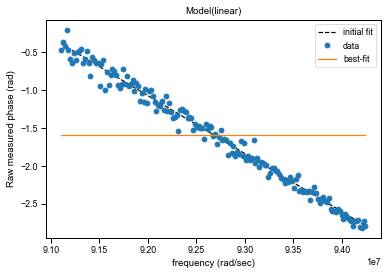

In [8]:
## why doesn't lmfit work?
result = lmfit.models.LinearModel().fit(y1, x=x1, slope = -7.66e-07, intercept = 69.4)
plt.plot(x1, result.init_fit, 'k--', label='initial fit')
result.plot_fit(xlabel='frequency (rad/sec)', ylabel="Raw measured phase (rad)")
## do not use!

In [9]:
print("Slope R1 = ", model1.coef_)
print("Offset R1 = ", model1.intercept_)
print("Error R1 = ", r_sq1)

# ((model1.intercept_ % (2 * np.pi)) / np.pi)

Slope R1 =  [-7.66267864e-07]
Offset R1 =  69.41594146426905
Error R1 =  0.9872408232495227


In [10]:
print("Slope R2 = ", model2.coef_)
print("Offset R2 = ", model2.intercept_)
print("Error R2 = ", r_sq2)

#(model2.intercept_ % (2 * np.pi)) / np.pi

Slope R2 =  [-7.36998817e-07]
Offset R2 =  66.51832725018828
Error R2 =  0.93064358789042


In [56]:
""" From Viva's google sheets calculation, which uses a longer mask:

According to the linear fits of phase versus frequency,
the time delay for R1 is 771 +/- 6 nanoseconds.
the time delay for R2 is 741 +/- 14 nanoseconds.
 
I was not that surprised that there is a 30 +/- 16 ns difference between the two resonators, 
but it did surprise me that R2 is apparently responding before R1.

For R1, the offset is 69.9+/- 0.5 radians.
For R2, the offset is 66.9 +/- 1.3 radians.
So the difference between intercepts is 3.0 +/- 1.4 radians."""

#Averages:
slope = np.mean([model1.coef_, model2.coef_])
print("average slope = ", slope)
intercept = np.mean([model1.intercept_, model2.intercept_])
print("average offset = ", intercept)

print("\nThe following values are also used in Mode Maps.ipynb to correct the phase:",
      "\naverage slope =  -7.51633340320429e-07",
      "\naverage offset =  67.96713435722867",
      "\nIf these don't agree with the above values, then be sure to fix Mode Maps to agree with whatever is current.")

############## THE CORRECTION! ##############
#Normalizes to the same phase
df1['radLin'] = df1.rad - (slope * df1.w + intercept)
df1['wrap'] = np.unwrap(df1.radLin)

df2['radLin'] = df2.rad - (slope * df2.w + intercept)
df2['wrap'] = np.unwrap(df2.radLin)

average slope =  -7.51633340320429e-07
average offset =  67.96713435722867

The following values are also used in Mode Maps.ipynb to correct the phase: 
average slope =  -7.51633340320429e-07 
average offset =  67.96713435722867 
If these don't agree with the above values, then be sure to fix Mode Maps to agree with whatever is current.


In [11]:
#print(df1.to_string())

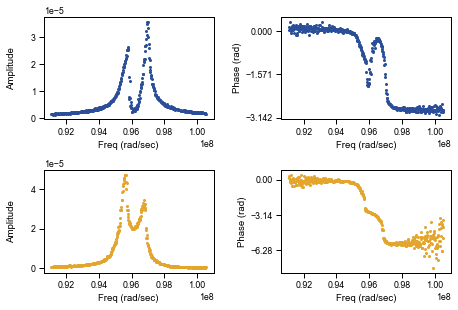

In [44]:
#Plots for paper

sns.set_context('paper')

m1_col = "#2A4F98"
m2_col = "#E4A52D"

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (7.3,4.7))

ax1.plot(df1.w, df1.R, '.', markersize = 4, color = m1_col)
ax1.set_xlabel('Freq (rad/sec)')
ax1.set_ylabel('Amplitude\n')

ax2.plot(df1.w, df1.wrap, '.', markersize = 4, color = m1_col)
ax2.set_xlabel('Freq (rad/sec)')
ax2.set_ylabel('Phase (rad)')
ax2.yaxis.set_major_locator(plt.MultipleLocator(np.pi/2))

ax3.plot(df2.w, df2.R, '.', markersize = 4, color = m2_col)
ax3.set_xlabel('Freq (rad/sec)')
ax3.set_ylabel('Amplitude\n')

ax4.plot(df2.w, df2.wrap, '.', markersize = 4, color = m2_col)
ax4.set_xlabel('Freq (rad/sec)')
ax4.set_ylabel('Phase (rad)')
ax4.yaxis.set_major_locator(plt.MultipleLocator(np.pi))

plt.subplots_adjust(hspace = 0.5, wspace = 0.4)

The linear fits are now forced to be the same, which makes the fits look a little high on the yellow R2 data and a little low on the blue R1 data, but still within the spread of datapoints.


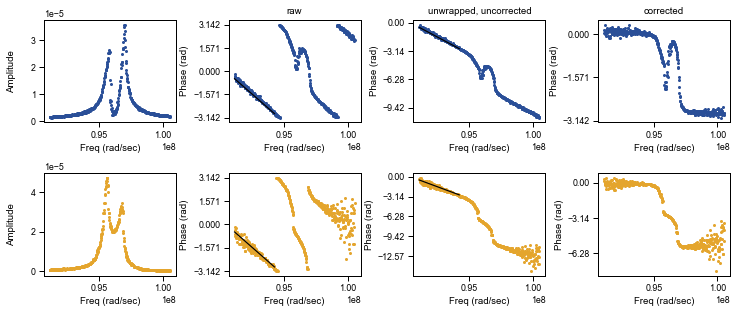

In [50]:
#All plots in radians

sns.set_context('paper')

m1_col = "#2A4F98"
m2_col = "#E4A52D"

fig, ((ax1, ax2, ax5, ax7), (ax3, ax4, ax6, ax8)) = plt.subplots(2, 4, figsize = (12.3,4.7)) 
                                            # formerly (7.3,4.7) for two columns

ax1.plot(df1.w, df1.R, '.', markersize = 4, color = m1_col)
ax1.set_xlabel('Freq (rad/sec)')
ax1.set_ylabel('Amplitude\n')

ax2.plot(df1.w, df1.rad, '.', markersize = 4, color = m1_col)
ax2.set_xlabel('Freq (rad/sec)')
ax2.set_ylabel('Phase (rad)')
ax2.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax2.set_title('raw')
#ax2.plot(df1.w[mk], model1.coef_*df1.w[mk] + model1.intercept_, color='k')
ax2.plot(df1.w[mk], slope*df1.w[mk] + intercept, color='k')

ax5.plot(df1.w, df1.rad_unwrapped_uncorrected, '.', markersize = 4, color = m1_col)
ax5.set_xlabel('Freq (rad/sec)')
ax5.set_ylabel('Phase (rad)')
ax5.yaxis.set_major_locator(plt.MultipleLocator(np.pi))
ax5.set_title('unwrapped, uncorrected')
#ax5.plot(df1.w[mk], model1.coef_*df1.w[mk] + model1.intercept_, color='k')
ax5.plot(df1.w[mk], slope*df1.w[mk] + intercept, color='k')

ax7.plot(df1.w, df1.wrap, '.', markersize = 4, color = m1_col)
ax7.set_xlabel('Freq (rad/sec)')
ax7.set_ylabel('Phase (rad)')
ax7.yaxis.set_major_locator(plt.MultipleLocator(np.pi/2))
ax7.set_title('corrected')

ax3.plot(df2.w, df2.R, '.', markersize = 4, color = m2_col)
ax3.set_xlabel('Freq (rad/sec)')
ax3.set_ylabel('Amplitude\n')

ax4.plot(df2.w, df2.rad, '.', markersize = 4, color = m2_col)
ax4.set_xlabel('Freq (rad/sec)')
ax4.set_ylabel('Phase (rad)')
ax4.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
#ax4.plot(df2.w[mk], model2.coef_*df2.w[mk] + model2.intercept_, color='k')
ax4.plot(df2.w[mk], slope*df2.w[mk] + intercept, color='k')

ax6.plot(df2.w, df2.rad_unwrapped_uncorrected, '.', markersize = 4, color = m2_col)
ax6.set_xlabel('Freq (rad/sec)')
ax6.set_ylabel('Phase (rad)')
ax6.yaxis.set_major_locator(plt.MultipleLocator(np.pi ))
#ax6.plot(df2.w[mk], model2.coef_*df2.w[mk] + model2.intercept_, color='k')
ax6.plot(df2.w[mk], slope*df2.w[mk] + intercept, color='k')

ax8.plot(df2.w, df2.wrap, '.', markersize = 4, color = m2_col)
ax8.set_xlabel('Freq (rad/sec)')
ax8.set_ylabel('Phase (rad)')
ax8.yaxis.set_major_locator(plt.MultipleLocator(np.pi))

print("The linear fits are now forced to be the same, which makes the fits look a little high on the yellow R2 data and a little low on the blue R1 data, but still within the spread of datapoints.")


plt.subplots_adjust(hspace = 0.5, wspace = 0.4)

In [14]:
#Define all variables

#individual springs that correspond to individual masses
k1 = sp.symbols('k_1')
k2 = sp.symbols('k_2')
k3 = sp.symbols('k_3')

#springs that connect two masses
k12 = sp.symbols('k_12')
k23 = sp.symbols('k_23')

#damping coefficients and forc
g = sp.symbols('g')
 
#masses
m1 = 7*(2.7*10**-17)
m2 = 7*(0.68*10**-17)
m3 = 7*(2.7*10**-17)

#Driving force amplitude
F = sp.symbols('F')

#driving frequency (leave as variable)
wd = sp.symbols('\omega_d')

In [15]:
#Solve for driving amplitudes and phase

#Matrix for complex equations of motion
driven = sp.Matrix([[-wd**2*m1 + 1j*wd*g + k1 + k12, -k12, 0], [-k12, -wd**2*m2 + 
  1j*wd*g + k2 + k12 + k23, -k23],[0, -k23, -wd**2*m3 + 1j*wd*g + k3 + k23]])

#Matrices for Cramer's Rule
driven_m1 = sp.Matrix([[F, -k12, 0], [0, -wd**2*m2 + 
  1j*wd*g + k2 + k12 + k23, -k23],[0, -k23, -wd**2*m3 + 1j*wd*g + k3 + k23]])

driven_m2 = sp.Matrix([[-wd**2*m1 + 1j*wd*g + k1 + k12, F, 0], [-k12, 0, -k23],[0, 0, -wd**2*m3 + 1j*wd*g + k3 + k23]])

driven_m3 = sp.Matrix([[-wd**2*m1 + 1j*wd*g + k1 + k12, -k12, F], [-k12, -wd**2*m2 + 
  1j*wd*g + k2 + k12 + k23, 0],[0, -k23, 0]])

#Apply Cramer's Rule
Cr1, Cr2, Cr3 = (driven_m1.det()/driven.det(),driven_m2.det()/driven.det(),driven_m3.det()/driven.det())

#Solve for phases for each mass
delta1 = sp.arg(Cr1)
delta2 = sp.arg(Cr2)
delta3 = sp.arg(Cr3)

#Wrap phases for plots

wrap1 = (delta1)%(2*np.pi)
wrap2 = (delta2)%(2*np.pi)
wrap3 = (delta3)%(2*np.pi)

#Solve for amplitude coefficients
amp1 = sp.re(Cr1)/sp.cos(delta1)
amp2 = sp.re(Cr2)/sp.cos(delta2)
amp3 = sp.re(Cr3)/sp.cos(delta3)

In [16]:
#lambdify curves

c1 = sp.lambdify((wd, k1, k2, k3, k12, k23, g, F),amp1)
t1 = sp.lambdify((wd, k1, k2, k3, k12, k23, g, F),wrap1)

c2 = sp.lambdify((wd, k1, k2, k3, k12, k23, g, F),amp2)
t2 = sp.lambdify((wd, k1, k2, k3, k12, k23, g, F),wrap2)

c3 = sp.lambdify((wd, k1, k2, k3, k12, k23, g, F),amp3)
t3 = sp.lambdify((wd, k1, k2, k3, k12, k23, g, F),wrap3)

#define functions

def curve1(w, k_1, k_2, k_3, k_12, k_23, g_, F_):
     return c1(w, k_1, k_2, k_3, k_12, k_23, g_, F_)
    
def theta1(w, k_1, k_2, k_3, k_12, k_23, g_, F_):
     return t1(w, k_1, k_2, k_3, k_12, k_23, g_, F_) - 2*np.pi
    
def curve2(w, k_1, k_2, k_3, k_12, k_23, g_, F_):
     return c2(w, k_1, k_2, k_3, k_12, k_23, g_, F_)
    
def theta2(w, k_1, k_2, k_3, k_12, k_23, g_, F_):
     return t2(w, k_1, k_2, k_3, k_12, k_23, g_, F_) - 2*np.pi
    
def curve3(w, k_1, k_2, k_3, k_12, k_23, g_, F_):
     return c3(w, k_1, k_2, k_3, k_12, k_23, g_, F_)
    
def theta3(w, k_1, k_2, k_3, k_12, k_23, g_, F_):
     return t3(w, k_1, k_2, k_3, k_12, k_23, g_, F_) - 2*np.pi
    
#Definte data

x1 = df1.F.values * 2 * np.pi
y1 = df1.R.values
th1 = df1.wrap.values

x2 = df2.F.values * 2 * np.pi
y2 = df2.R.values
th2 = df2.wrap.values

In [17]:
def residual(params, w1, w2, data_amp1, data_phase1, data_amp2, data_phase2):
    k_1 = params['k1']
    k_2 = params['k2']
    k_3 = params['k3']
    k_12 = params['k12']
    k_23 = params['k23']
    g_ = params['g']
    F_ = params['F']
    
    model1 = curve1(w1, k_1, k_2, k_3, k_12, k_23, g_, F_)
    model2 = theta1(w1, k_1, k_2, k_3, k_12, k_23, g_, F_)
    model3 = curve2(w2, k_1, k_2, k_3, k_12, k_23, g_, F_)
    model4 = theta2(w2, k_1, k_2, k_3, k_12, k_23, g_, F_)
    
    resid1 = data_amp1 - model1
    resid2 = data_phase1 - model2
    resid3 = data_amp2 - model3
    resid4 = data_phase2 - model4

    return np.concatenate((resid1, resid2, resid3, resid4))

params2 = lmfit.Parameters()
params2.add('k1', value = 1.75, min = 0)
params2.add('k2', value = 0.4, min = 0)
params2.add('k3', value = 1.75, min = 0)
params2.add('k12', value = 0.01, min = 0)
params2.add('k23', value = 0.01, min = 0)
params2.add('g', value = 10**-11, min = 0)
params2.add('F', value = 10**-6, min = 0)

out = lmfit.minimize(residual, params2, args = (x1, x2, y1, th1, y2, th2))

k_1 = out.params['k1'].value
k_2 = out.params['k2'].value
k_3 = out.params['k3'].value
k_12 = out.params['k12'].value
k_23 = out.params['k23'].value
g = out.params['g'].value
F = out.params['F'].value

print(lmfit.fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 301
    # data points      = 2000
    # variables        = 7
    chi-square         = 212.366616
    reduced chi-square = 0.10655625
    Akaike info crit   = -4471.17671
    Bayesian info crit = -4431.97040
##  Warning: uncertainties could not be estimated:
    g:    at initial value
    g:    at boundary
[[Variables]]
    k1:   1.75224578 (init = 1.75)
    k2:   0.42529364 (init = 0.4)
    k3:   1.79859376 (init = 1.75)
    k12:  0.01021803 (init = 0.01)
    k23:  0.00376512 (init = 0.01)
    g:    1.0000e-11 (init = 1e-11)
    F:    4.9391e-08 (init = 1e-06)


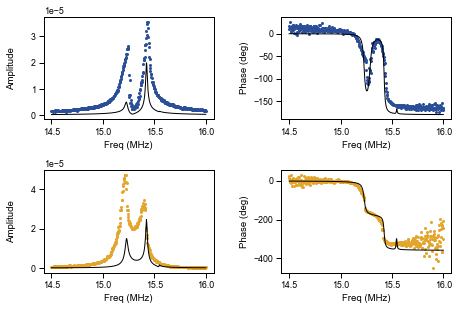

In [18]:
#Plots for paper

sns.set_context('paper')

m1_col = "#2A4F98"
m2_col = "#E4A52D"

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (7.3,4.7))

ax1.plot(x1/(2*np.pi*10**6), y1, '.', markersize = 4, color = m1_col)
ax1.plot(x1/(2*np.pi*10**6), curve1(x1, k_1, k_2, k_3, k_12, k_23, g, F), '-', color='black', linewidth = 1)
ax1.set_xlabel('Freq (MHz)')
ax1.set_ylabel('Amplitude\n')

ax2.plot(x1/(2*np.pi*10**6), th1*180/np.pi, '.', markersize = 4, color = m1_col)
ax2.plot(x1/(2*np.pi*10**6), theta1(x1, k_1, k_2, k_3, k_12, k_23, g, F)*180/np.pi, '-', color='black', linewidth = 1)
ax2.set_xlabel('Freq (MHz)')
ax2.set_ylabel('Phase (deg)')

ax3.plot(x2/(2*np.pi*10**6), y2, '.', markersize = 4, color = m2_col)
ax3.plot(x2/(2*np.pi*10**6), curve2(x2, k_1, k_2, k_3, k_12, k_23, g, F), '-', color='black', linewidth = 1)
ax3.set_xlabel('Freq (MHz)')
ax3.set_ylabel('Amplitude\n')

ax4.plot(x2/(2*np.pi*10**6), th2*180/np.pi, '.', markersize = 4, color = m2_col)
ax4.plot(x2/(2*np.pi*10**6), theta2(x2, k_1, k_2, k_3, k_12, k_23, g, F)*180/np.pi, '-', color='black', linewidth = 1)
ax4.set_xlabel('Freq (MHz)')
ax4.set_ylabel('Phase (deg)')

plt.subplots_adjust(hspace = 0.5, wspace = 0.4)

#fig.savefig('/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports/CoupledResonanceCurvesAndFits.pdf', bbox_inches= 'tight', pad_inches=0.05)

In [19]:
print(df1[["F","wrap"]].to_string())

                F      wrap
0    1.450000e+07  0.161657
1    1.450301e+07  0.280071
2    1.450601e+07  0.231685
3    1.450902e+07  0.462520
4    1.451202e+07  0.212451
5    1.451503e+07  0.107307
6    1.451804e+07  0.066533
7    1.452104e+07  0.210275
8    1.452405e+07  0.140935
9    1.452705e+07  0.252979
10   1.453006e+07  0.286301
11   1.453307e+07  0.315958
12   1.453607e+07  0.150156
13   1.453908e+07  0.222159
14   1.454208e+07  0.342975
15   1.454509e+07  0.189196
16   1.454810e+07  0.035957
17   1.455110e+07  0.299269
18   1.455411e+07  0.270674
19   1.455711e+07  0.249175
20   1.456012e+07  0.259399
21   1.456313e+07 -0.026772
22   1.456613e+07  0.273454
23   1.456914e+07  0.349511
24   1.457214e+07 -0.036552
25   1.457515e+07  0.210190
26   1.457816e+07  0.061578
27   1.458116e+07  0.197927
28   1.458417e+07  0.294398
29   1.458717e+07  0.278249
30   1.459018e+07  0.244413
31   1.459319e+07  0.125673
32   1.459619e+07  0.101965
33   1.459920e+07  0.170879
34   1.460220e+07  0

In [20]:
df1

,SweepVal,F,R,theta,NEP_BW,R_ref,theta_ref,Amp,Phase,rad,w,rad_unwrapped_uncorrected,theta_unwrapped_uncorrected,radLin,wrap
0,1.450000e+07,1.450000e+07,0.000002,-26.652136,25.255763,0.0,0.0,0.000002,-26.652136,-0.465168,9.110619e+07,-0.465168,-26.652136,0.161657,0.161657
1,1.450301e+07,1.450301e+07,0.000001,-20.665090,25.255763,0.0,0.0,0.000001,-20.665090,-0.360674,9.112507e+07,-0.360674,-20.665090,0.280071,0.280071
2,1.450601e+07,1.450601e+07,0.000001,-24.234961,25.255763,0.0,0.0,0.000001,-24.234961,-0.422980,9.114396e+07,-0.422980,-24.234961,0.231685,0.231685
3,1.450902e+07,1.450902e+07,0.000001,-11.806639,25.255763,0.0,0.0,0.000001,-11.806639,-0.206065,9.116285e+07,-0.206065,-11.806639,0.462520,0.462520
4,1.451202e+07,1.451202e+07,0.000001,-26.932100,25.255763,0.0,0.0,0.000001,-26.932100,-0.470054,9.118174e+07,-0.470054,-26.932100,0.212451,0.212451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.598798e+07,1.598798e+07,0.000002,121.339306,25.255763,0.0,0.0,0.000002,121.339306,2.117770,1.004554e+08,-10.448600,-598.660694,9.634966,-2.931405
496,1.599098e+07,1.599098e+07,0.000002,120.365063,25.255763,0.0,0.0,0.000002,120.365063,2.100767,1.004743e+08,-10.465604,-599.634937,9.631882,-2.934489
497,1.599399e+07,1.599399e+07,0.000002,117.992221,25.255763,0.0,0.0,0.000002,117.992221,2.059353,1.004932e+08,-10.507018,-602.007779,9.604388,-2.961983
498,1.599699e+07,1.599699e+07,0.000002,122.420642,25.255763,0.0,0.0,0.000002,122.420642,2.136643,1.005121e+08,-10.429727,-597.579358,9.695598,-2.870772


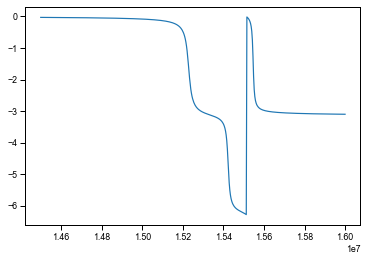

In [21]:
#plt.plot(df1.Fnorm,curve3(x2, k_1, k_2, k_3, k_12, k_23, g, F))
plt.plot(df1.F,theta3(x1, k_1, k_2, k_3, k_12, k_23, g, F))

In [22]:
data = np.array([df1.Fnorm,theta3(x1, k_1, k_2, k_3, k_12, k_23, g, F)])

r3 = pd.DataFrame(data = data)

R3= r3.transpose()

print(R3.to_string())

AttributeError: 'DataFrame' object has no attribute 'Fnorm'